# A basic neural network library supported auto differentiation

## Outline

- Motivation
- Introduction
- Implementation
- Application
- Software engineering

---

## Motivation

Most deep learning courses aim to teach math behind the network, architecture and their applications, but seldom course talk about how to implement and design the deep learning library.

### Goal

- Implement this kind of library
- Learn how and why the priors (Tensorflow and PyTorch etc.) design their work.

---

## Introduction

### Computational Graph

We can represent the computations by using computation graph.

The node represent input and operation, and the edge represent the argument of the operation.

For example, we have the computation like $(3-2) + 1$ (which will be visited again), the corresponding graph is

![forward](forward.png)

Note that the order of arguments matters (3 should be on top of 2 etc.), but unfortunately the plot toolkits is hard to control that.

### Back propagation

The forward pass builds the graph, and the backward propagation calculate the gradient.

Use the last example we used $(3 - 2) + 1$, but transform it into algebraic way $z = (a - b) + c$.

Suppose we want to compute the gradient of `z` w.r.t. `c`, it's easily obtained by using the chain rule.

$$\frac{\partial (a-b) + c}{\partial c} = 1$$

Now we want gradient w.r.t. `b`, again we use the chain rule.

Before that, we decompose operation into different equation in order to introduce auto differentiation.

$$
\begin{aligned}
z &= (a - b) + c \\
\Rightarrow z &= d + c
\end{aligned}
$$

$$
\begin{aligned}
\frac{\partial (a-b) + c}{\partial b} &= \frac{\partial (d + c)}{\partial d} \times \frac{\partial d}{\partial b} \\
 &= 1 \times \frac{\partial (a - b)}{\partial b} \\
 &= 1 \times -1 \\
 &= -1
\end{aligned} 
$$

### Auto Differentiation

We visit the last example again, all we need to know to calculate the gradient w.r.t. `d` is

- Current operation node: add
- Input argument: d and c
- Previous gradient (upstream): 1 (I didn't say but it is actually 1 in the begining)

$$\frac{\partial (d + c)}{\partial d} = 1$$

We know that `d` is the first argument of `add` operation, so after taking derivative w.r.t `d`, result becomes $1 \times 1$ and we get 1, note that the first one is the upstream, and the second one is the derivative result.

Now we get the gradient w.r.t. `d`, and because `d` is equal to `(a - b)`, so we pass the computed gradient (downstream) to their parent node (`a` and `b`, respectively), now we move forward (actually it's backward).

Now we move ourselves to node `b` to compute the gradient w.r.t. `b`, and the current information are

- Current operation node: sub
- Input argument: a and b
- Previous gradient (upstream): 1

$$ \frac{\partial (a - b)}{\partial b} = -1$$

Because `b` is the second argument of `sub` operation, so the result is $1 \times -1$ which is -1, and again, first 1 is the upstream, and the second -1 is the derivative result.

The point I want to emphasize is that, it seems easy to get the derivative w.r.t. any variable without any decomposition because it's easy, but what if we want to compute the gradient of following eqation w.r.t. `z` directly in the following equation?

$$y = \frac{1}{1 + e^{-z}}$$ 

The philosophy of auto differntiation is that we don't take derivative directly, we decompose it into different primitive function and solve derivative of each decomposed function and combine together because we have chain rule got our back.

So how does auto-diff solve the previous equation?

It will decompose into

- negative
- exp
- add
- reciprocal

and solve each function previously listed.

### VJP

VJP stands for vector-jacobian product, this is usually the product between upstream and the derivative w.r.t one of the argument of operation. I will not elaborate here and it's highly recommended to take a look at [Automatic Differentiation, Toronto CSC321](http://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf).

In the much simple way, you can think that what's the computation we want to do to get the downstream w.r.t any argument in any operation node.

## Implementation

### Forward Propagation

Q: How do we obtain the computational graph?

A: Trace every operation with the wrapped version by decorator.

#### Examples:

That's say we want to print the numpy function name during the calculation.

We can fully leverage the power of decorator.

In [1]:
%matplotlib inline 

import numpy as np


def get_name_decorator(func):
    def wrapped(*args, **kwargs):
        print(f"Wrapped version of numpy function, and its name is {func.__name__}")
        result = func(*args, **kwargs)
        return result
    return wrapped
        

for function in [np.add, np.subtract, np.ndarray.__getitem__, np.ndarray.__add__]:
    globals()[function.__name__] = get_name_decorator(function)

print(add(1, 2))
print(subtract(1, 2))
print(__getitem__(np.array([0,1,2]), [2]))
print(__add__(np.array([0,1]), np.array([1,0])))

Wrapped version of numpy function, and its name is add
3
Wrapped version of numpy function, and its name is subtract
-1
Wrapped version of numpy function, and its name is __getitem__
[2]
Wrapped version of numpy function, and its name is __add__
[1 1]


Now things have been little complicated. Due to the same reason, we can put the operator on the computational graph on the fly.

In [2]:
class Node:
    def __init__(self):
        self.gradient = 0

class OperationNode(Node):
    def __init__(self, func, args, kwargs, result):
        super().__init__()
        self.recipe = (func, args, kwargs, result, len(args))


class VariableNode(Node):
    def __init__(self, var):
        super().__init__()
        self.var = var


class PlaceholderNode(Node):
    def __init__(self, var):
        super().__init__()
        self.var = var


class ConstantNode(Node):
    def __init__(self, constant):
        super().__init__()
        self.constant = constant

def plot_graph(backward=False, backward_result={}):
    arrow_style = "<|-" if backward else "-|>" 
    edge_labels = {}
    if backward:
        info = "output"
        node_index = add_node(node=ConstantNode(info), info=info)
        default_graph.add_edge(node_index - 1, node_index)
        for node, result in backward_result.items():
            for edge in default_graph.edges:
                head, tail = edge
                if head == node:
                    edge_labels[tuple(edge)] = str(result)
        edge_labels[(node_index, node_index-1)] = "1"
    plt.figure(3,figsize=(10,10)) 
    limits=plt.axis('off')
    labels = {i: default_graph.nodes[i]['info'] for i in default_graph.nodes}
    pos = nx.spring_layout(default_graph)
    nx.draw_networkx_nodes(default_graph, pos, node_size = 3000, alpha=0.8)
    nx.draw_networkx_labels(default_graph, pos, labels=labels, font_color="w")
    nx.draw_networkx_edges(default_graph, pos, width=3, arrowstyle=arrow_style, arrowsize=15)
    if backward:
        nx.draw_networkx_edge_labels(default_graph,pos,edge_labels=edge_labels,font_size=30)
    plt.show()     

Forward pass
Result is 2
Corresponding computational graph is 


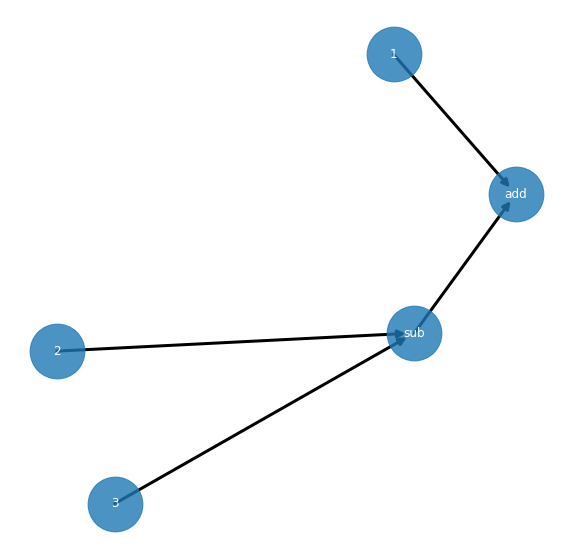

In [11]:
import warnings

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cbook

warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore", category=RuntimeWarning)

default_graph = nx.DiGraph()
stack = []

def add_node(node, info):
    node_index = len(default_graph.nodes) + 1
    default_graph.add_node(node_index, node=node, info=info)
    return node_index


def constant(array):
    def wrapped(*args, **kwargs):
        node = ConstantNode("".join(str(a) for a in args))
        node_index = add_node(node, *args)
        stack.append(node_index)
        value = array(*args, **kwargs)
        return value
    return wrapped

        
def primitive(func):
    def wrapped(*args, **kwargs):
        result = func(*args, **kwargs)
        node = OperationNode(func, args, kwargs, result)
        node_index = add_node(node, func.__name__[:3])
        parents = stack[-len(args):]
        
        for parent in parents:
            default_graph.add_edge(parent, node_index)
            stack.pop()
        
        stack.append(node_index)
        return result
    return wrapped
        

def wrapped_numpy_operator():
    for function in [np.add, np.subtract]:
        globals()[function.__name__] = primitive(function)

    globals()["const"] = constant(np.array)


wrapped_numpy_operator()
result = add(const(1), subtract(const(3), const(2)))
print("Forward pass")
print(f"Result is {result}")
print("Corresponding computational graph is ")
plot_graph()

### Register VJP after loading

- We need to look up the corresponding VJP of given operation while backtracking.
- Register all VJP at loading time in `__init__.py`

We can easily validate our result with numerical calculation (which can be used in test), which is
$$f'(x) = \lim_{\epsilon\to 0} \frac{f(x + \epsilon / 2) - f(x - \epsilon / 2)}{\epsilon}$$

In [4]:
from collections import defaultdict

import numpy as np

# Register the VJP in memory
primitive_vhp = defaultdict(dict)

def register_vjp(func, vhp_list):
    for i, downstream in enumerate(vhp_list):
        primitive_vhp[func.__name__][i] = downstream

register_vjp(
    np.add,
    [
        lambda upstream, result, x, y: upstream,  # w.r.t. x
        lambda upstream, result, x, y: upstream,  # w.r.t. y
    ])

register_vjp(
    np.subtract,
    [
        lambda upstream, result, x, y: upstream,  # w.r.t. x
        lambda upstream, result, x, y: -upstream,  # w.r.t. y
    ])

register_vjp(
    np.negative,
    [
        lambda upstream, result, x: -upstream,  # w.r.t. x
    ])

# This is the numerical way to calculate the derivatives

epsilon = 1e-4

def numerical_vjp(func, arguments, wrt):
    args_pos = [args + epsilon/2 if i == wrt else args for i, args in enumerate(arguments)]
    func_pos = func(*args_pos)
    args_neg = [args - epsilon/2 if i == wrt else args for i, args in enumerate(arguments)]
    func_neg = func(*args_neg)
    return (func_pos - func_neg) / epsilon
    
func = np.negative
x = -6
upstream = 1
result = func(x)
vjp = primitive_vhp[func.__name__][0]

print(f"Upstream is {upstream}")
print(f"Operator is {func.__name__}, x is {x}, result is {result}")
print(f"Downstream is {vjp(upstream, result, x)}")
print(f"Numerical result is {numerical_vjp(func, [x], 0)}")

Upstream is 1
Operator is negative, x is -6, result is 6
Downstream is -1
Numerical result is -0.9999999999976694


### Backward Propagation

Backward pass


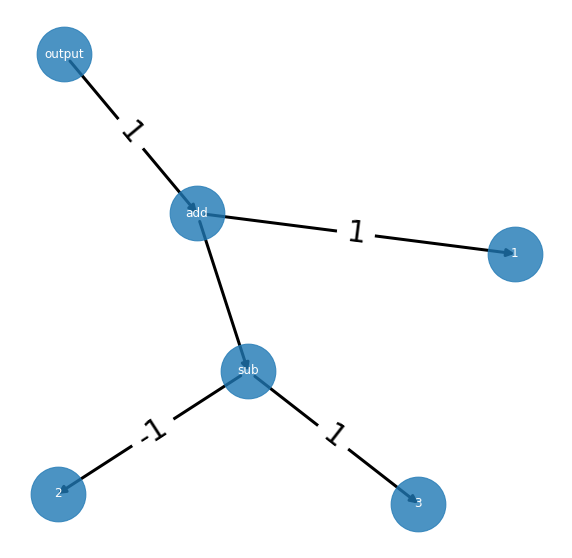

In [5]:
import networkx as nx

def backward_prop(upstream):
    default_graph.nodes[len(default_graph.nodes())]['node'].gradient = upstream

    gradient_dict = {}
    for node in reversed(list(nx.topological_sort(default_graph))):
        child_node = default_graph.nodes[node]['node']
        if isinstance(child_node, OperationNode):
            func, args, kwargs, result, arg_num = child_node.recipe
            upstream = child_node.gradient

            for i, parent in zip(range(arg_num), default_graph.predecessors(node)):
                vhp = primitive_vhp[func.__name__][i]
                downstream = vhp(upstream, result, *args, **kwargs)
                default_graph.nodes[parent]['node'].gradient += downstream
        else:
            gradient_dict[node] = child_node.gradient

    return gradient_dict

print("Backward pass")
backward_result = backward_prop(np.ones_like(result))
plot_graph(True, backward_result)

---
## Application

### Simple demo

We want to compute the derivatives of $x^3$, which is $3x^2$.

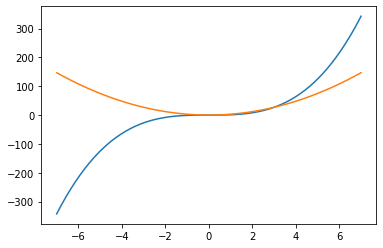

<Figure size 432x288 with 0 Axes>

In [6]:
%run examples/simple/poly_test.py

Blue line is $x^3$, and the orange line is $3x^2$.

### Boston house dataset – linear regression with multiple variables

Description: 13 numerical attributes, and our target is predicting house price.

Criterion: Mean Square Error

100%|██████████| 200/200 [00:00<00:00, 1747.03it/s]


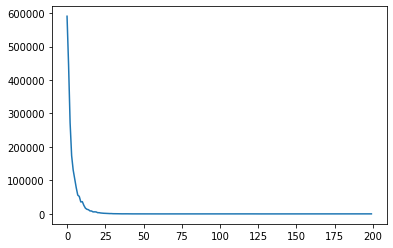

In [7]:
%run examples/regression/boston.py

### Iris dataset – classification 

Description: 4 attributes, predict one of class over 3 classes.

Criterion: Cross Entropy

100%|██████████| 300/300 [00:00<00:00, 1527.80it/s]


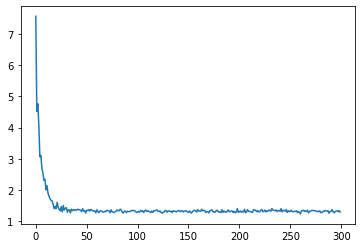

In [8]:
%run examples/classification/iris.py

### Hand-written digits dataset – classification

Description: 8 * 8 image attribute, predict which digit (0-9) is

Criterion: Cross Entropy

100%|██████████| 300/300 [00:00<00:00, 1615.85it/s]


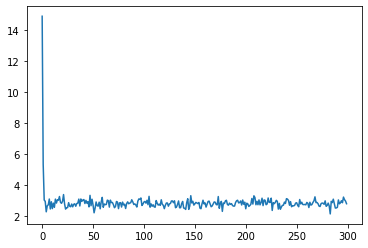

In [9]:
%run examples/classification/digits.py

---
## Software engineering

### Unit Test

Reference the test case from google/jax. So far, We have already covered the test for value and vjp.

We test different shape including scalar, vector and matrix.

In [10]:
! pytest autodiff/tests

============================= test session starts ==============================
platform linux -- Python 3.7.4, pytest-5.2.1, py-1.8.0, pluggy-0.13.0
rootdir: /home/chenyee/AutoDiff-from-scratch
plugins: arraydiff-0.3, remotedata-0.3.2, openfiles-0.4.0, doctestplus-0.4.0, forked-1.1.3, xdist-1.30.0
collected 78 items                                                             

autodiff/tests/autodiff_test.py .......................................  [ 50%]
autodiff/tests/numpy_test.py .......................................     [100%]

============================== 78 passed in 0.35s ==============================


### Open Source contributions

Find the redundant calculations of the derivatives of power function.
1. [PyTorch](https://github.com/pytorch/pytorch/pull/28651)
2. [JAX](https://github.com/google/jax/pull/157)
3. [Autograd](https://github.com/HIPS/autograd/pull/541)